# Load Libraries

In [1]:
# !pip install scikit-image

In [22]:
import tensorflow
import os,sys
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import shuffle
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize
from keras.datasets import cifar10

import numpy as np
import random

import tensorflow as tf
random.seed(1)
np.random.seed(1)
tf.random.set_seed(2)

In [3]:
import os
os.getcwd()
print(os.listdir())

['.ipynb_checkpoints', 'celeb_dataset_128.npz', 'celeb_generator_model_128.h5', 'FID Score For Celeb  DataSet.ipynb']


# FID Score Function 

In [4]:
# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        new_image = resize(image, new_shape)
        images_list.append(new_image)
    return asarray(images_list)

In [5]:
# calculate frechet inception distance
def calculate_fid(model, images1, images2):
    # calculate activations
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = numpy.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# Load InceptionV3 Model

In [6]:
# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

# Original Data

In [7]:
# load Animo images
images1 = np.load("celeb_dataset_128.npz")['arr_0']
shuffle(images1)
images1 = images1[:3000]
print('Loaded', images1.shape)

Loaded (3000, 128, 128, 3)


In [8]:
ok = images1[0][:,:,0]
print(ok.shape)
# print(argmax(ok))
# for i in ok:
#     for j in i:
#         print(j)
#     print('\n')

(128, 128)


# Plot Function

In [9]:
import matplotlib.pyplot as plt
def save_plot(x_input,n=4):
    # x_input = (x_input + 1) / 2.0
    # x_input = x_input.reshape((x_input.shape[0],28,28,1))
    for i in range(n*n):
        plt.subplot(n, n, i+1)
        plt.imshow(x_input[i,:,:,:])
        plt.axis('off')
    plt.show()
# plot data
# save_plot(k[:16])

# Plot Original Data

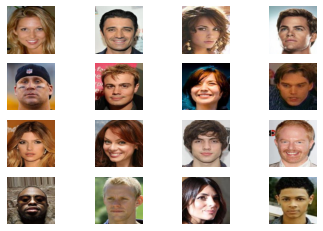

In [10]:
# original images
save_plot(images1)

# Load Generator Model

In [11]:
# load generator model
generator = tensorflow.keras.models.load_model("celeb_generator_model_128.h5")

# Generate Data

In [12]:
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    z_input = x_input.reshape(n_samples, latent_dim)
    z = np.random.randint(0,7,size=(n_samples))
    return [z_input,z]

In [13]:
from numpy import *
from numpy.random import *

# generated images
latent_dim = 512
n_samples = 3000
# x_input = randn(latent_dim * n_samples)
# # print(x_input.shape)
# z_input = x_input.reshape(n_samples, latent_dim)
# # print(z_input.shape)
# pred = loaded_model.predict(z_input)

latent_points, labels = generate_latent_points(latent_dim= latent_dim, n_samples= n_samples)
pred  = generator.predict([latent_points, labels])

94/94 [==============================] - 288s 3s/step


# Plot Generated Data

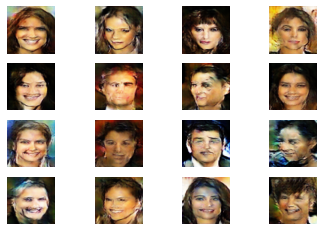

In [14]:
# Generated images
X1 = pred[:30]
X1 = (X1 + 1)/2.0
save_plot(X1,n=4)

# Calculate FID Score

In [15]:
# scale data into [-1, 1]
# pred = (pred + 1)/2.0
images1 = (images1 - 127.5)/127.5

In [16]:
# we are calculating for 1000 images
images1 = images1[:3000]
images2 = pred[:3000]

In [17]:
# convert integer to floating point values
images1 = images1.astype('float32')
images2 = images2.astype('float32')

In [18]:
# resize images
images1 = scale_images(images1, (299,299,3))
images2 = scale_images(images2, (299,299,3))
print('Scaled', images1.shape, images2.shape)

Scaled (3000, 299, 299, 3) (3000, 299, 299, 3)


In [19]:
# pre-process images
images1 = preprocess_input(images1)
images2 = preprocess_input(images2)

In [20]:
# calculate fid
fid = calculate_fid(model, images1, images2)
print('FID: %.3f' % fid)

94/94 [==============================] - 424s 5s/step
FID: 0.761


In [21]:
print("FID Score: %.4f" %fid)

FID Score: 0.7606
